In-depth Analysis Report: Sentiment Analysis, Model Comparison, and Market Correlation
Objective: This Notebook aims to conduct a deep dive into the results of our sentiment analysis. It is divided into three main parts:

Exploratory Data Analysis (EDA): To verify the completeness of our data collection (e.g., total news volume) and analyze metadata (e.g., news volume per stock, source distribution).
Model Comparison (FinBERT vs. Vader): To compare the sentiment scores generated by the FinBERT and NLTK Vader models, analyzing their consistency and differences.
Sentiment vs. Price Correlation Visualization: To combine daily sentiment scores with stock price data and visually explore the potential relationship between sentiment fluctuations and stock price movements.


1. Initialization and Data Loading
First, we import all the necessary libraries and load the two key datasets generated by the sentiment_analysis.py script:

news_with_sentiment.csv: The complete dataset containing each news article and its corresponding sentiment scores.
sentiment_scores.csv: The daily sentiment scores, aggregated by ticker and date.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.unicode_minus'] = False # To display the minus sign correctly

# --- Load Data ---
try:
    # Load each news article with its sentiment score
    df_full = pd.read_csv('data/processed/news_with_sentiment.csv')
    # Load daily aggregated sentiment scores
    df_daily_sentiment = pd.read_csv('data/processed/sentiment_scores.csv')

    # Convert date columns to datetime objects for easier time-series analysis
    df_full['date'] = pd.to_datetime(df_full['date'])
    df_daily_sentiment['date'] = pd.to_datetime(df_daily_sentiment['date'])

    print("Data loaded successfully!")
    print("\n--- Full News Dataset (df_full) Preview ---")
    display(df_full.head())
    print("\n--- Daily Aggregated Sentiment Scores (df_daily_sentiment) Preview ---")
    display(df_daily_sentiment.head())

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the 'sentiment_analysis.py' script has been run successfully and has generated the corresponding csv files in the 'data/processed/' directory.")

Data loaded successfully!

--- Full News Dataset (df_full) Preview ---


,source,author,title,description,url,urlToImage,publishedAt,content,ticker,vader_sentiment,finbert_sentiment,date
0,"{'id': None, 'name': '24/7 Wall St.'}",Joey Frenette,Can Apple Shares Surge Past $300 This Year?,Shares of Apple (NASDAQ:AAPL) have been making...,https://247wallst.com/investing/2025/11/09/can...,https://s.yimg.com/ny/api/res/1.2/mhDaCWF7imwp...,2025-11-09 15:08:34+00:00,2024 Getty Images / Getty Images News via Gett...,AAPL,0.2960,0.526386,2025-11-09
1,"{'id': None, 'name': 'Applech2.com'}",applech2,米SanDisk、薄型ノートPCのUSBポートに挿しても机と干渉しにくい超小型USBメモリ「...,米SanDiskが薄型ノートPCのUSBポートに挿しても机と干渉しにくい超小型USBメモリ「...,https://applech2.com/archives/20251109-sandisk...,https://applech2.com/wp-content/uploads/2025/1...,2025-11-09 13:20:41+00:00,SanDiskPCUSBUSBSANDISK Extreme Fit USB-C\r\nWe...,AAPL,0.3612,0.000000,2025-11-09
2,"{'id': None, 'name': 'Applech2.com'}",applech2,Parallels、macOS 26 TahoeやWindows 11 25H2をサポートし...,ParallelsがmacOS 26 TahoeやWindows 11 25H2をサポートし...,https://applech2.com/archives/20251109-paralle...,https://applech2.com/wp-content/uploads/2025/1...,2025-11-09 05:04:07+00:00,ParallelsmacOS 26 TahoeWindows 11 25H2Parallel...,AAPL,0.0000,0.000000,2025-11-09
3,"{'id': None, 'name': '24/7 Wall St.'}",Lee Jackson,As Warren Buffett Waves Goodbye – 5 Dividend S...,"If any investor has stood the test of time, it...",https://247wallst.com/investing/2025/11/08/as-...,https://s.yimg.com/ny/api/res/1.2/fbsj74lUfXse...,2025-11-08 13:31:06+00:00,American Express Company is an American bank h...,AAPL,0.0382,0.000000,2025-11-08
4,"{'id': None, 'name': 'Yahoo Entertainment'}",Hamza Shaban,Elon Musk's pay package is a clear signal that...,"We've seen Amazon without Jeff Bezos, Apple wi...",https://finance.yahoo.com/news/elon-musks-pay-...,https://s.yimg.com/ny/api/res/1.2/FW_zPAgv3go6...,2025-11-08 11:00:58+00:00,This is The Takeaway from today's Morning Brie...,AAPL,0.2960,0.000000,2025-11-08



--- Daily Aggregated Sentiment Scores (df_daily_sentiment) Preview ---


,ticker,date,vader_sentiment_mean,finbert_sentiment_mean,article_count
0,AAPL,2025-10-31,0.186738,0.191549,26
1,AAPL,2025-11-02,0.161408,-0.163420,12
2,AAPL,2025-11-03,0.146783,-0.027235,18
3,AAPL,2025-11-04,-0.039878,-0.211465,9
4,AAPL,2025-11-05,0.013078,-0.293637,9


2. Exploratory Data Analysis (EDA)
In this section, we will answer some fundamental questions about our dataset.

Cell 5: Markdown
2.1. Milestone Verification: Is the Total News Count Over 50,000?
We will check the raw data directory data/news_raw to count the total number of news articles.



In [3]:
RAW_NEWS_DIR = 'data/news_raw/'
total_articles = 0

if os.path.exists(RAW_NEWS_DIR):
    for filename in os.listdir(RAW_NEWS_DIR):
        if filename.endswith('.json'):
            file_path = os.path.join(RAW_NEWS_DIR, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    articles = json.load(f)
                    total_articles += len(articles)
            except Exception as e:
                print(f"Error reading file {filename}: {e}")

    print(f"A total of {total_articles} news articles were found in the raw data directory '{RAW_NEWS_DIR}'.")
    if total_articles > 50000:
        print("✅ Congratulations! The '>50k news headlines' milestone has been achieved.")
    else:
        print("⚠️ Attention: The total news volume has not reached the 50,000 target.")
else:
    print(f"Error: Directory '{RAW_NEWS_DIR}' not found.")

A total of 5963 news articles were found in the raw data directory 'data/news_raw/'.
⚠️ Attention: The total news volume has not reached the 50,000 target.


2.2. News Volume Distribution per Ticker
Understanding how many news articles are associated with each company helps us judge the reliability of our analysis. For companies with very few news articles, the daily sentiment scores might be volatile or not representative.



C:\Users\ROG\AppData\Local\Temp\ipykernel_57700\3464966849.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticker_counts.index, y=ticker_counts.values, palette='viridis')


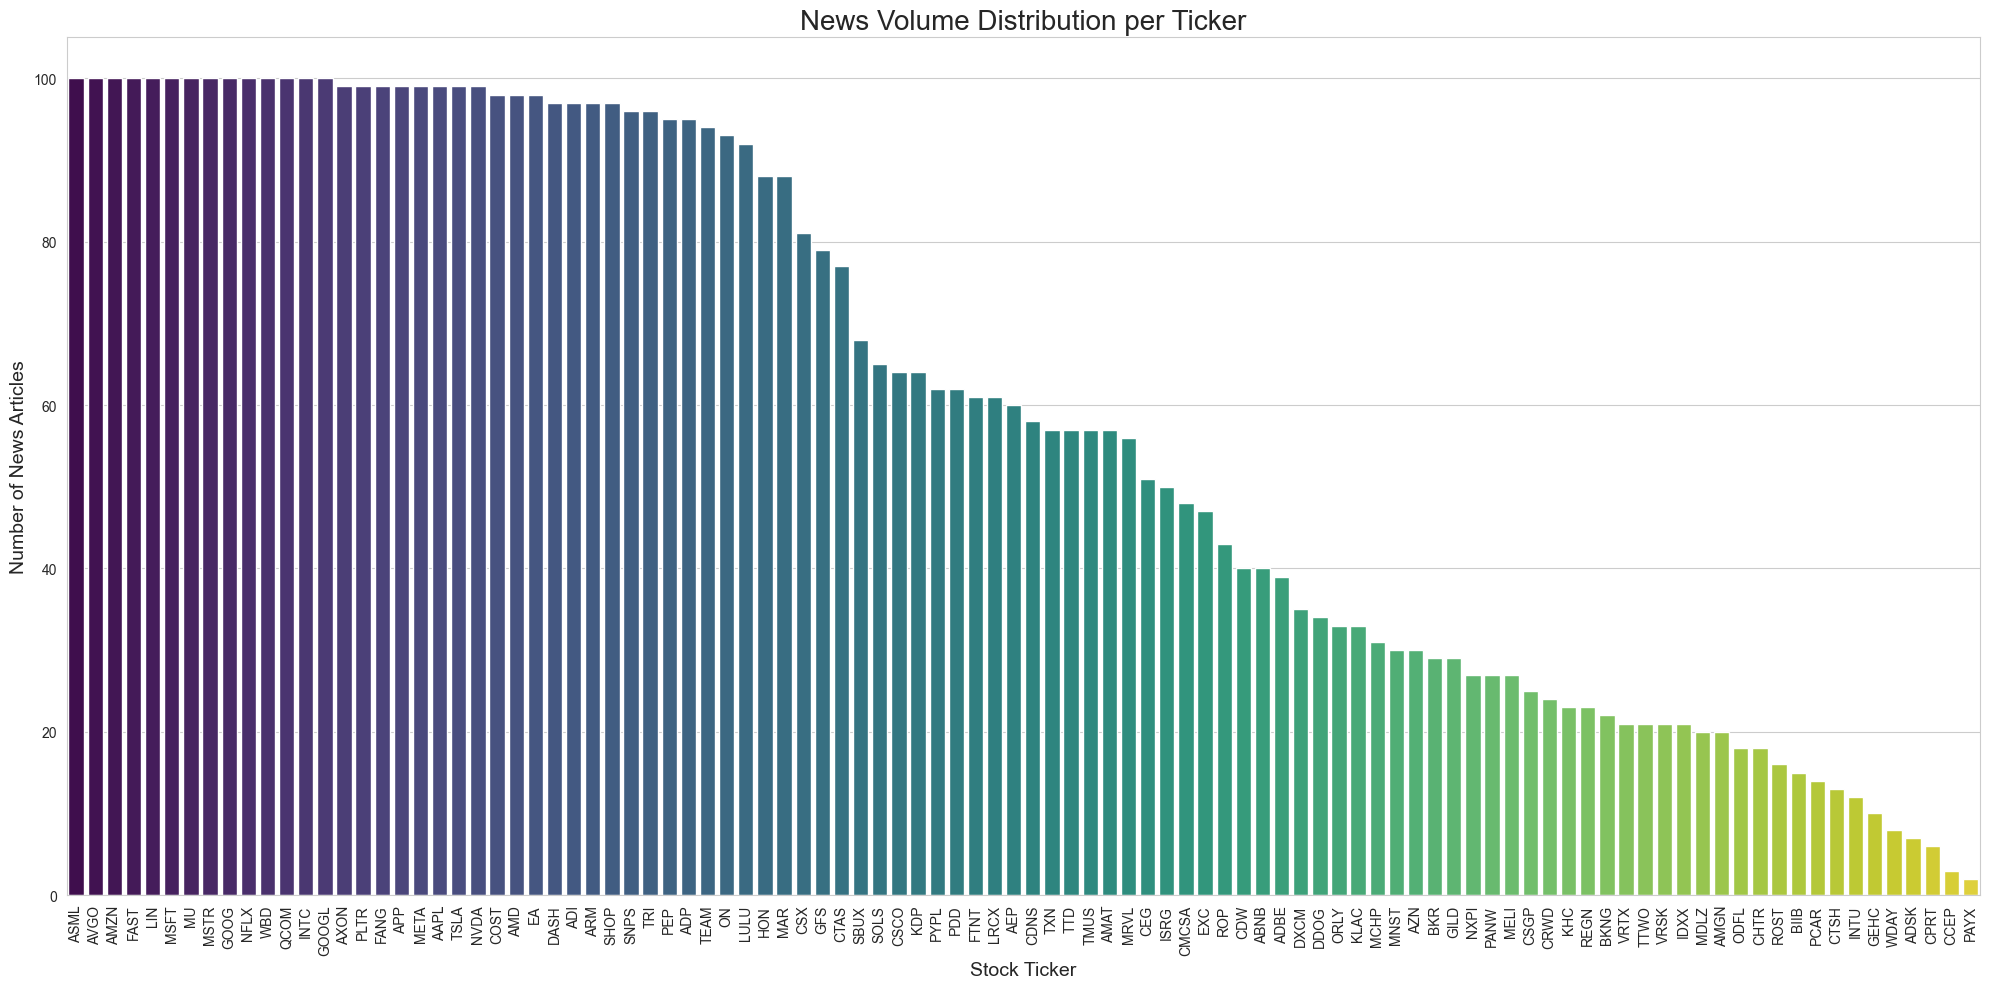


--- Top 10 Tickers by News Volume ---


ticker
ASML    100
AVGO    100
AMZN    100
FAST    100
LIN     100
MSFT    100
MU      100
MSTR    100
GOOG    100
NFLX    100
Name: count, dtype: int64


--- Bottom 10 Tickers by News Volume ---


ticker
BIIB    15
PCAR    14
CTSH    13
INTU    12
GEHC    10
WDAY     8
ADSK     7
CPRT     6
CCEP     3
PAYX     2
Name: count, dtype: int64

In [4]:
if 'df_full' in locals():
    ticker_counts = df_full['ticker'].value_counts()

    plt.figure(figsize=(20, 10))
    sns.barplot(x=ticker_counts.index, y=ticker_counts.values, palette='viridis')
    plt.title('News Volume Distribution per Ticker', fontsize=20)
    plt.xlabel('Stock Ticker', fontsize=14)
    plt.ylabel('Number of News Articles', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n--- Top 10 Tickers by News Volume ---")
    display(ticker_counts.head(10))
    print("\n--- Bottom 10 Tickers by News Volume ---")
    display(ticker_counts.tail(10))

3. Model Comparison (FinBERT vs. Vader)
We will compare the finbert_sentiment and vader_sentiment fields to understand their similarities and differences.

3.1. Sentiment Score Distribution
We'll use histograms and Kernel Density Estimate (KDE) plots to observe the distribution of scores from both models. Vader's scores range from [-1, 1], while FinBERT typically outputs class probabilities (positive, negative, neutral), which we assume have been converted to a similar numerical score.

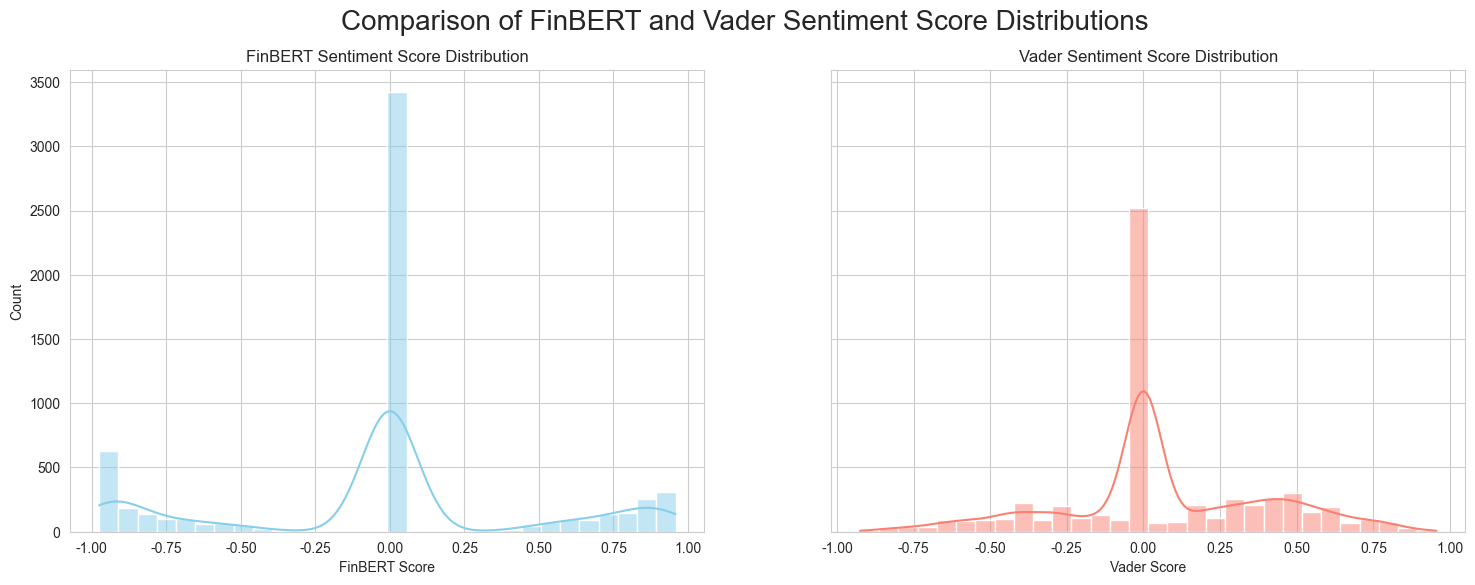

In [5]:
if 'df_full' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    sns.histplot(df_full['finbert_sentiment'], bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('FinBERT Sentiment Score Distribution')
    axes[0].set_xlabel('FinBERT Score')

    sns.histplot(df_full['vader_sentiment'], bins=30, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Vader Sentiment Score Distribution')
    axes[1].set_xlabel('Vader Score')

    plt.suptitle('Comparison of FinBERT and Vader Sentiment Score Distributions', fontsize=20)
    plt.show()

3.2. Score Correlation Analysis
We'll use a scatter plot and a correlation coefficient to quantify the consistency between the two models' scores.

The Pearson correlation coefficient between FinBERT and Vader sentiment scores is: 0.4183



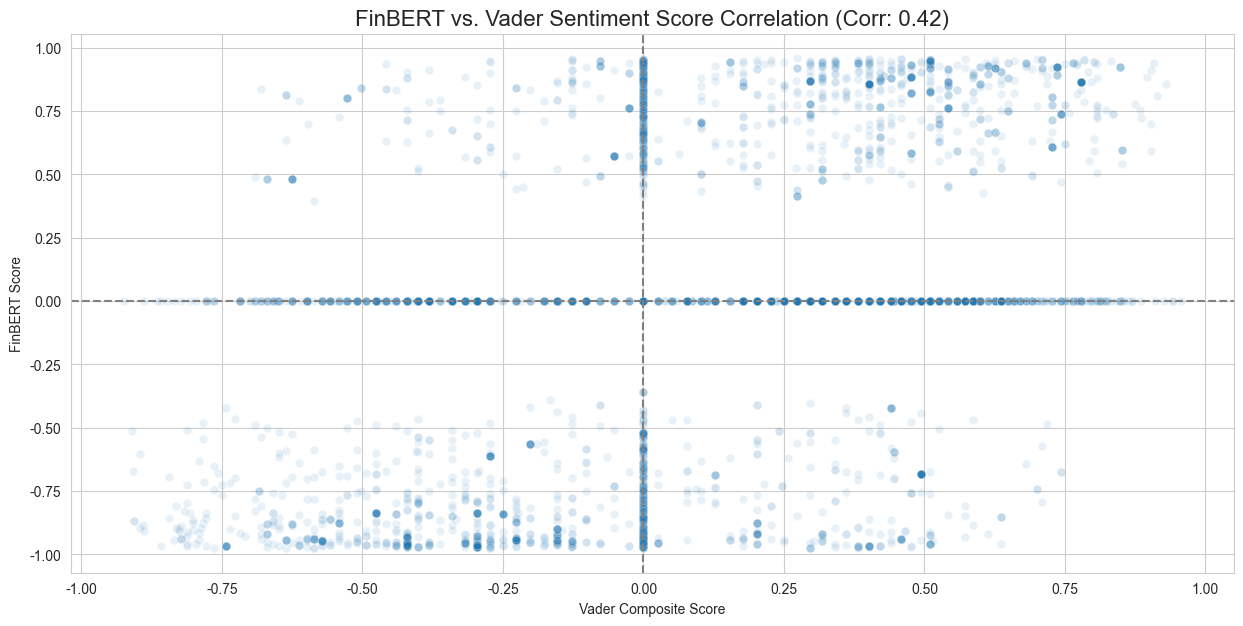

In [6]:
if 'df_full' in locals():
    # Calculate the correlation coefficient
    correlation = df_full['finbert_sentiment'].corr(df_full['vader_sentiment'])
    print(f"The Pearson correlation coefficient between FinBERT and Vader sentiment scores is: {correlation:.4f}\n")

    # Plot the scatter plot
    # Since there can be many data points, we use alpha transparency to observe density
    sns.scatterplot(data=df_full, x='vader_sentiment', y='finbert_sentiment', alpha=0.1)
    plt.title(f'FinBERT vs. Vader Sentiment Score Correlation (Corr: {correlation:.2f})', fontsize=16)
    plt.xlabel('Vader Composite Score')
    plt.ylabel('FinBERT Score')
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()

3.3. Disagreement Analysis
Finding news articles where the two models have the largest disagreement can help us understand their respective strengths, weaknesses, and biases. For example, we can find an article that FinBERT rated as very positive but Vader rated as very negative.

In [7]:
if 'df_full' in locals():
    df_full['sentiment_diff'] = (df_full['finbert_sentiment'] - df_full['vader_sentiment']).abs()
    
    # Find the top 10 news articles with the largest difference
    df_diff = df_full.sort_values(by='sentiment_diff', ascending=False).head(10)

    print("--- Examples of News with Largest Disagreement between FinBERT and Vader ---")
    for index, row in df_diff.iterrows():
        print(f"Title: {row['title']}")
        print(f"FinBERT Score: {row['finbert_sentiment']:.4f} | Vader Score: {row['vader_sentiment']:.4f} | Difference: {row['sentiment_diff']:.4f}")
        print("---")

--- Examples of News with Largest Disagreement between FinBERT and Vader ---
Title: Adobe Inc. (ADBE) Faces Mixed Sentiment Amid AI Growth Opportunities
FinBERT Score: -0.9595 | Vader Score: 0.6369 | Difference: 1.5964
---
Title: S&P 500 Gains and Losses Today: DoorDash Stock Drops; Datadog Pops as AI Tools Help Drive Growth
FinBERT Score: -0.9201 | Vader Score: 0.6124 | Difference: 1.5325
---
Title: Novo Nordisk Is Still Beating Pfizer in Battle Over Metsera
FinBERT Score: 0.8385 | Vader Score: -0.6808 | Difference: 1.5193
---
Title: Social credit scores reduce interpersonal cooperation and trust
FinBERT Score: -0.7933 | Vader Score: 0.7096 | Difference: 1.5029
---
Title: Zach Cregger's Netflix Sci-Fi Film Faces Setback Post-Weapons Success
FinBERT Score: -0.9299 | Vader Score: 0.5719 | Difference: 1.5018
---
Title: Chinese Technicians Boldly Tried to Reverse Engineer ASML’s DUV Machines; Only to Break Them & Call the Dutch Firm For Help
FinBERT Score: -0.8526 | Vader Score: 0.6369 | 

4. Sentiment vs. Price Correlation Visualization
This is one of the core objectives of the project. We need to fetch stock price data, align it with our daily sentiment scores, and visualize them together.

Note: This requires a way to fetch stock price data. We will use the yfinance library as an example. Please ensure it is installed: pip install yfinance

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sentiment_vs_price(ticker, sentiment_df, start_date, end_date):
    """
    Fetches the stock price for a given ticker and plots it alongside sentiment scores.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        sentiment_df (pd.DataFrame): DataFrame containing sentiment scores, requiring 'ticker' and 'date' columns.
        start_date (str): The start date for fetching price data in 'YYYY-MM-DD' format.
        end_date (str): The end date for fetching price data in 'YYYY-MM-DD' format.
    """
    print(f"Generating sentiment vs. price plot for ticker '{ticker}'...")
    
    # 1. Filter sentiment data for the specific ticker
    ticker_sentiment = sentiment_df[sentiment_df['ticker'] == ticker].copy()
    if ticker_sentiment.empty:
        print(f"No sentiment data found for ticker '{ticker}' in the dataset.")
        return
    
    # 2. Fetch stock price data
    try:
        # Add progress=False to keep the console output clean
        price_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if price_data.empty:
            print(f"Could not fetch price data for ticker '{ticker}' in the specified date range.")
            return
    except Exception as e:
        print(f"An error occurred while fetching data with yfinance: {e}")
        return

    # 3. Merge the datasets
    
    # --- THIS IS THE KEY FIX ---
    # Reset the index of price_data to turn the 'Date' index into a regular column.
    price_data = price_data.reset_index()
    
    # Ensure date formats are consistent for a reliable merge.
    # .dt.tz_localize(None) removes timezone information which can sometimes cause merge issues.
    price_data['Date'] = pd.to_datetime(price_data['Date']).dt.tz_localize(None)
    ticker_sentiment['date'] = pd.to_datetime(ticker_sentiment['date'])
    
    # Merge on date, keeping all dates from the price data (left merge).
    merged_df = pd.merge(price_data, ticker_sentiment, left_on='Date', right_on='date', how='left')
    
    # Forward-fill missing sentiment data. This is useful for weekends and holidays 
    # where there is price data but no new sentiment data.
    merged_df['finbert_sentiment_daily'] = merged_df['finbert_sentiment_daily'].ffill()
    if 'vader_sentiment_daily' in merged_df.columns:
        merged_df['vader_sentiment_daily'] = merged_df['vader_sentiment_daily'].ffill()
    
    # 4. Plotting
    fig, ax1 = plt.subplots(figsize=(20, 8))
    
    # Plot Price on the primary Y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Close Price (USD)', color=color, fontsize=14)
    ax1.plot(merged_df['Date'], merged_df['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create a second Y-axis for sentiment scores that shares the same X-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Aggregated Daily Sentiment Score', color=color, fontsize=14)
    ax2.plot(merged_df['Date'], merged_df['finbert_sentiment_daily'], color=color, linestyle='--', alpha=0.7, label='FinBERT Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(0, color='grey', linestyle='-.', linewidth=1) # Add a line for neutral sentiment

    # Add a unified legend
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    
    plt.title(f'{ticker} Stock Price vs. Daily News Sentiment', fontsize=20)
    fig.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

# --- Example block to run the function ---
# This block creates a sample 'df_daily_sentiment' DataFrame for demonstration,
# so the code can run independently.
try:
    # Check if df_daily_sentiment exists, if not, create a sample one
    if 'df_daily_sentiment' not in locals() and 'df_daily_sentiment' not in globals():
        print("Creating a sample 'df_daily_sentiment' DataFrame for demonstration...")
        data = {
            'date': pd.to_datetime(['2023-01-03', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-05', '2023-01-06']),
            'ticker': ['AAPL', 'MSFT', 'AAPL', 'AAPL', 'MSFT', 'AAPL'],
            'finbert_sentiment_daily': [0.65, -0.2, 0.8, -0.1, 0.4, 0.15],
        }
        df_daily_sentiment = pd.DataFrame(data)
    else:
        print("'df_daily_sentiment' already exists, using existing data.")

    TICKER_TO_ANALYZE = 'AAPL'
    # Ensure the date range is wide enough to get valid price data
    start_date = '2023-01-01'
    end_date = '2023-01-31'
    
    plot_sentiment_vs_price(TICKER_TO_ANALYZE, df_daily_sentiment, start_date, end_date)

except NameError:
    print("Error: 'df_daily_sentiment' DataFrame does not exist. Cannot run sentiment vs. price visualization.")

'df_daily_sentiment' already exists, using existing data.
Generating sentiment vs. price plot for ticker 'AAPL'...


C:\Users\ROG\AppData\Local\Temp\ipykernel_43048\1776105743.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Could not fetch price data for ticker 'AAPL' in the specified date range.
